In [20]:
import keras
import cv2
import os
import keras.layers
import sklearn
import numpy as np


#########################################################
########################Configration#####################
train_path="sample/processedTrain"
test_path="sample/processedTest"


valid_path="sample/validation"
#train\0cya_16378348962584395.png

height = 64
width = 256
n_len = 4
input_shape = (height,width,3)  # 根据验证码图片尺寸调整
num_classes = 36  # 验证码字符种类数
batch_size = 64
steps = 32  # 每个epoch的训练步数
epochs = 5
n_len=4

pre_train_total_num=5000
import string
characters = string.digits + string.ascii_lowercase
############################################################

In [21]:


# 读取训练集和测试集
def read_img(path):
    img_list = []
    cnt=0
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename)) 
        cnt+=1
        if cnt>pre_train_total_num:
            break
        # print(img.shape)
        img_list.append(img)
    return img_list

#训练集和测试集
# train_images=read_img(train_path)
# valid_images=read_img(valid_path)
# test_images=read_img(test_path)


In [22]:
def one_hot_encode(path):
    ans_label=[]
    cnt=0
    for filename in os.listdir(path):
        cnt+=1
        if cnt>pre_train_total_num:
            break
        filename=filename[:4]
        label=[[0 for i in range(num_classes)]
                for j in range(len(filename))]

        for i in range(len(filename)):
            label[i][characters.index(filename[i])]=1
        


        ans_label.append(label)
    return ans_label

In [23]:
class CaptchaSequence(keras.utils.Sequence):
    def __init__(self,img_dir,characters,batch_size,steps=steps,n_len=4,width=width,height=height):
        self.characters=characters
        self.batch_size=batch_size
        self.steps=steps
        self.n_len=n_len
        self.width=width
        self.height=height
        self.n_class=len(characters)

        self.img_paths = []  # 存储所有图片路径
        self.labels = []  # 存储对应标签
        # 遍历目录，加载图片路径和标签
        for filename in os.listdir(img_dir):
            img_path = img_dir +'/' + filename  # 图片路径
            pos=filename.rfind('.')

            self.img_paths.append(img_path)
            label = filename[pos-4:pos]
            self.labels.append(label)
        
        
    def __len__(self):
        return self.steps
    def __getitem__(self,idx):
        x=np.zeros((self.batch_size,self.height,self.width,3),dtype=np.float32)
        #初始化图片数据全是0，按固定输入维度
        y=[np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        #初始化4个输出[4个输出层，batch_size,n_classes]
        for i in range(self.batch_size):
            if idx * self.batch_size + i >= len(self.img_paths):
                idx = 0  # 或者其他处理方式以避免重复
            img_path = self.img_paths[idx * self.batch_size + i]
            label = self.labels[idx * self.batch_size + i]
            # 加载图片并调整尺寸
            img = cv2.imread(img_path)
            img = cv2.resize(img, (self.width, self.height))
            x[i] = img.astype(np.float32) / 255.0  # 归一化
            for j, ch in enumerate(label):
                y[j][i, :] = 0
                y[j][i, characters.find(ch.lower() if ch.isalpha() else ch)] = 1

        return x,y
    


In [24]:
from keras.models import *
from keras.layers import *
input_tensor=Input(input_shape)

x=input_tensor

print(x.shape)

for i,n_cnn in enumerate([2,2,2]):
    for j in range(n_cnn):
        x=Conv2D(32*2**min(i,3),kernel_size=3,padding='same',kernel_initializer='he_uniform')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=Dropout(0.1)(x)
    x=MaxPooling2D(2)(x)
    
x=Flatten()(x)
x=Dropout(0.20)(x)
x=[Dense(num_classes,activation='softmax',name='c%d'%(i+1))(x) for i in range(n_len)]
model=Model(inputs=input_tensor,outputs=x)


print(model.summary())

#模型训练
# 导入EarlyStopping,CSVLogger,ModelCheckpoint等回调函数
from keras.callbacks import EarlyStopping,CSVLogger,ModelCheckpoint
# 导入Adam优化器
from keras.optimizers import *

# 初始化CaptchaSequence对象，参数分别为：训练集路径、字符集、批量大小、训练步数
train_data=CaptchaSequence(train_path,characters,batch_size=batch_size,steps=steps)
# 初始化CaptchaSequence对象，参数分别为：验证集路径、字符集、批量大小、验证步数
valid_data=CaptchaSequence(valid_path,characters,batch_size=batch_size,steps=steps)

# 定义回调函数，参数分别为：早停的轮数、日志文件名、保存最优模型的文件名
callbacks=[EarlyStopping(patience=7),CSVLogger('cnn.csv'),ModelCheckpoint('cnn_best.h5',save_best_only=True)]

# 编译模型，参数分别为：交叉熵损失函数、优化器、评估指标
model.compile(loss='categorical_crossentropy',
                optimizer=Adam(1e-3,amsgrad=True),
                metrics=['accuracy'])
# 训练模型，参数分别为：训练数据、训练轮数、验证数据、回调函数
history=model.fit(train_data,
          epochs=epochs,
        #   validation_data=valid_data,
          callbacks=callbacks)

model.save('model/cnn3.h5')


(None, 64, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 256, 32)  896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 256, 32)  128        ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                         

In [25]:


def gen(img_dir,batch_size=128):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, num_classes), dtype=np.uint8) for i in range(n_len)]
    
    imgs=[]
    labels=[]
    for filename in os.listdir(img_dir):
        img_path = img_dir + '/' + filename

        # print(filename)
        pos=filename.rfind('.')

        # print(filename[pos-4:pos])
        labels.append(filename[pos-4:pos])
        img=cv2.imread(img_path)
        img=cv2.resize(img, (width, height))
        img=img.astype(np.float32)/255.0
        imgs.append(img)
    
    idx=0
    while True:
        for i in range(batch_size):
            if idx*batch_size+i>=len(imgs):
                idx=0
            X[i]=imgs[idx*batch_size+i]
            for j, ch in enumerate(labels[idx*batch_size+i]):
                y[j][i, :] = 0
                y[j][i, characters.find(ch.lower() if ch.isalpha() else ch)] = 1
        idx+=1
        yield X, y


def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

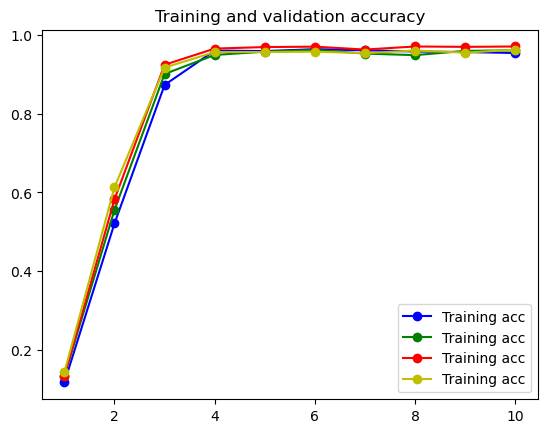

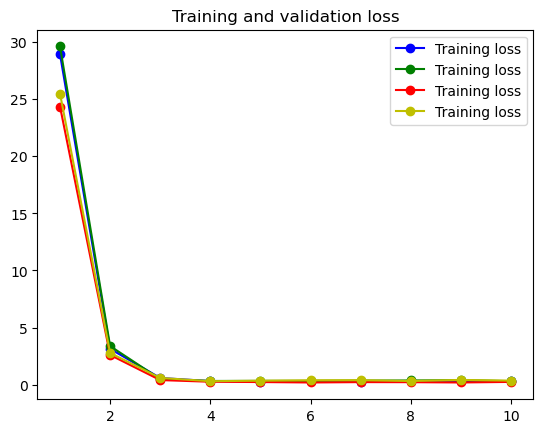

In [26]:
import matplotlib.pyplot as plt

# print(history.history)


c1_accuracy = history.history['c1_accuracy']
c2_accuracy = history.history['c2_accuracy']
c3_accuracy = history.history['c3_accuracy']
c4_accuracy = history.history['c4_accuracy']

c1_loss=history.history['c1_loss']
c2_loss=history.history['c2_loss']
c3_loss=history.history['c3_loss']
c4_loss=history.history['c4_loss']

# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

x_epochs = range(1, len(c1_accuracy) + 1)

plt.plot(x_epochs, c1_accuracy, 'bo', label='Training acc',linestyle='-')
plt.plot(x_epochs, c2_accuracy, 'go', label='Training acc',linestyle='-')
plt.plot(x_epochs, c3_accuracy, 'ro', label='Training acc',linestyle='-')
plt.plot(x_epochs, c4_accuracy, 'yo', label='Training acc',linestyle='-')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(x_epochs, c1_loss, 'bo', label='Training loss',linestyle='-')
plt.plot(x_epochs, c2_loss, 'go', label='Training loss',linestyle='-')
plt.plot(x_epochs, c3_loss, 'ro', label='Training loss',linestyle='-')
plt.plot(x_epochs, c4_loss, 'yo', label='Training loss',linestyle='-')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [27]:
test = model.evaluate(gen(test_path),batch_size=batch_size,steps=20)
# print('Test accuracy:', test_acc)

print(type(test))
print(test[-4:])

20/20 [==============================] - 23s 1s/step - loss: 5.0296 - c1_loss: 1.0153 - c2_loss: 1.9232 - c3_loss: 1.0959 - c4_loss: 0.9951 - c1_accuracy: 0.7105 - c2_accuracy: 0.6254 - c3_accuracy: 0.7648 - c4_accuracy: 0.7785
<class 'list'>
[0.7105468511581421, 0.6253906488418579, 0.764843761920929, 0.778515636920929]


In [28]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model



dir_path="sample/processedPredict"
rgb_path="sample/new_train/predict"
predict_batch_size=90

# model=load_model('model/cnn1.h5')


files=[]
for filename in os.listdir(rgb_path):
    files.append(rgb_path + '/' + filename)
    # files.append(dir_path + '/' + filename)

X, _ = next(gen(dir_path,90))
for i in range(predict_batch_size):
    x_pred=X[i]
    x_pred=np.expand_dims(x_pred,axis=0)
    
    y_pred = decode(model.predict(x_pred))


    img=cv2.imread(files[i])
    img=cv2.resize(img,(width,height))
    cv2.putText(img,y_pred,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)

    cv2.imshow('img',img)
    cv2.waitKey(0)
# files=[]
# for filename in os.listdir(dir_path):
#     files.append(dir_path + '/' + filename)

# x=np.zeros((batch_size,width,height,3),dtype=np.float32)
# for i in range(batch_size):
#     img=cv2.imread(files[i])
#     img=cv2.resize(img,(width,height))
#     x[i]=img.astype(np.float32)/255.0

# y_pred=np.array(model.predict(x))

# for i in range(batch_size):
#     img=files[i]
#     img=cv2.imread(img)
#     img=cv2.resize(img,(width,height))
    
#     cv2.putText(img,decode(y_pred[:,i,:]),(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
#     cv2.imshow('img',img)
#     cv2.waitKey(0)

1/1 [==============================] - 0s 24ms/step


KeyboardInterrupt: 